In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
import os
os.chdir("/content/gdrive/My Drive/cs747/CS747_Assignment3")
%ls
!pip3 install torch torchvision
import torch
a = torch.Tensor([1]).cuda()
print(a)

Mounted at /content/gdrive
celeba_data/         MP3_P1.ipynb
download_celeba.sh   q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
gan/                 Spring_2023_CS_747_Deep_Learning_Assignment-3.pdf
GAN_debugging.ipynb  Untitled0.ipynb
gan_samples/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tensor([1.], device='cuda:0')


# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



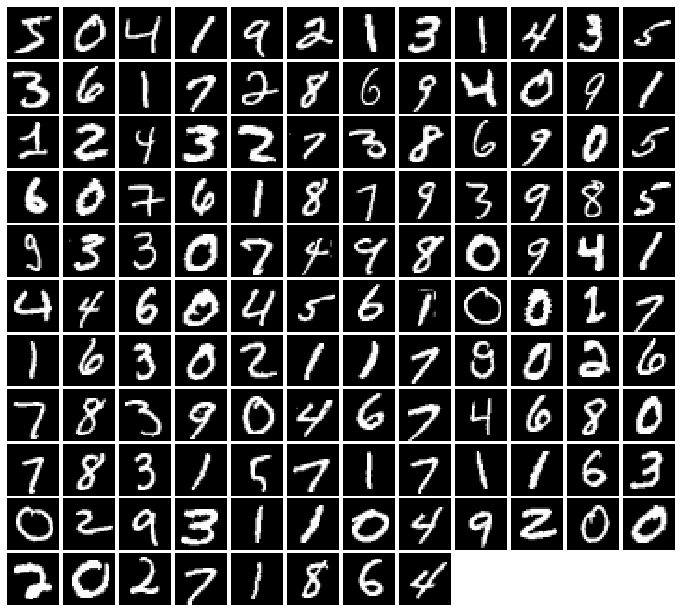

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

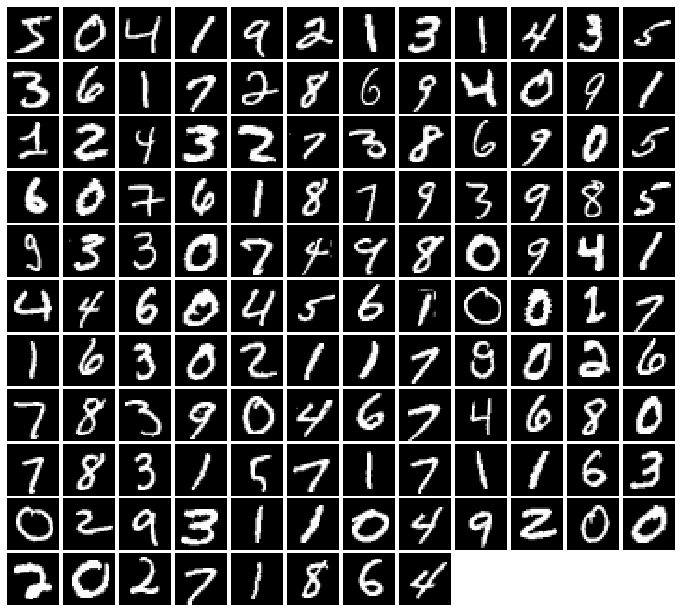

In [5]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)

imgs = next(iter(loader_train))[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [7]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [8]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 0.726, G:0.702


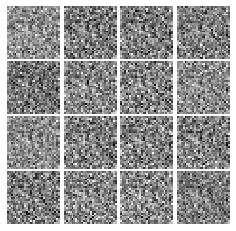


Iter: 250, D: 0.6321, G:0.9215


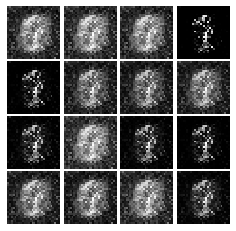


EPOCH:  2
Iter: 500, D: 0.6142, G:1.328


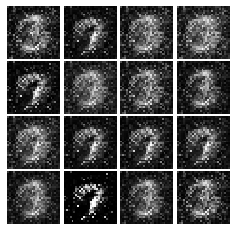


Iter: 750, D: 0.6242, G:1.282


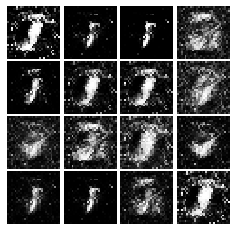


EPOCH:  3
Iter: 1000, D: 0.5043, G:1.48


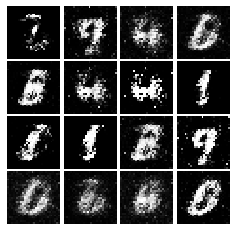


Iter: 1250, D: 0.5736, G:1.074


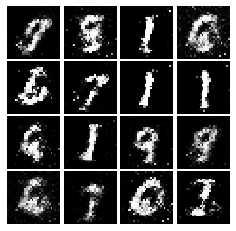


EPOCH:  4
Iter: 1500, D: 0.5493, G:1.075


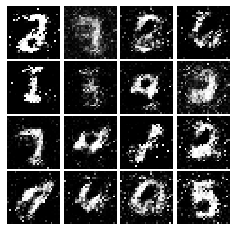


Iter: 1750, D: 0.5451, G:1.136


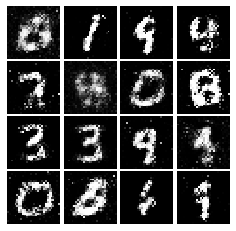


EPOCH:  5
Iter: 2000, D: 0.5744, G:0.8538


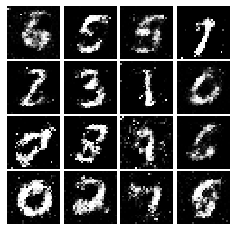


Iter: 2250, D: 0.5944, G:0.969


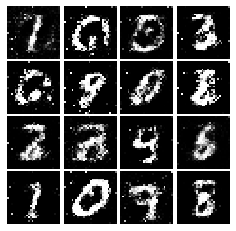


EPOCH:  6
Iter: 2500, D: 0.5939, G:1.009


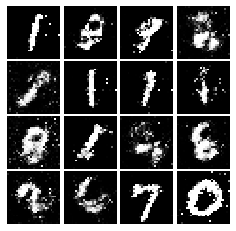


Iter: 2750, D: 0.6582, G:0.8297


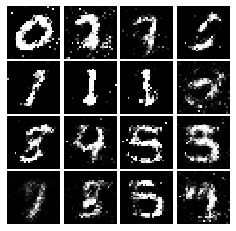


EPOCH:  7
Iter: 3000, D: 0.6591, G:0.891


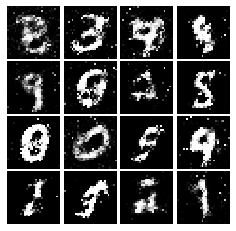


Iter: 3250, D: 0.6306, G:0.9353


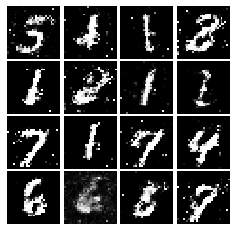


EPOCH:  8
Iter: 3500, D: 0.5686, G:0.9309


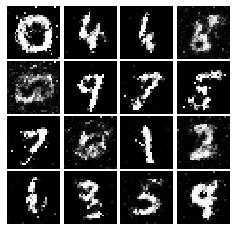


EPOCH:  9
Iter: 3750, D: 0.64, G:1.105


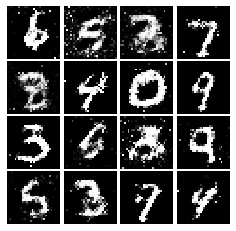


Iter: 4000, D: 0.6911, G:0.7123


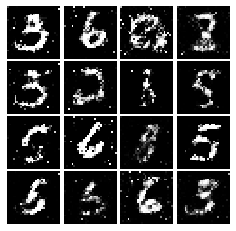


EPOCH:  10
Iter: 4250, D: 0.6251, G:0.8828


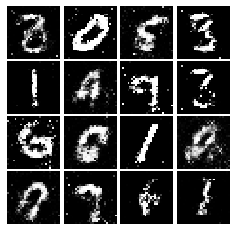


Iter: 4500, D: 0.6487, G:0.8577


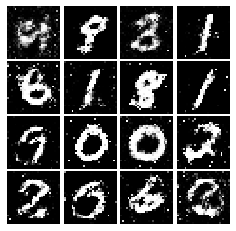

In [9]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.6201, G:0.5148


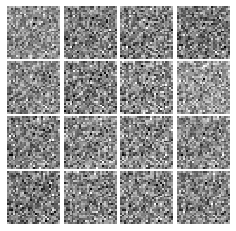


Iter: 250, D: 0.0841, G:0.3944


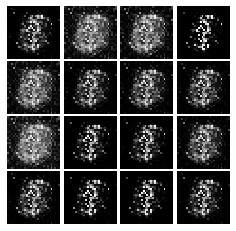


EPOCH:  2
Iter: 500, D: 0.1069, G:0.3986


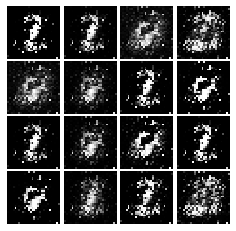


Iter: 750, D: 0.2423, G:0.02725


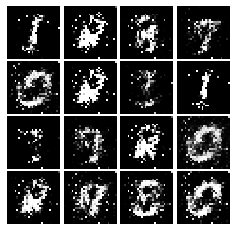


EPOCH:  3
Iter: 1000, D: 0.1104, G:0.3665


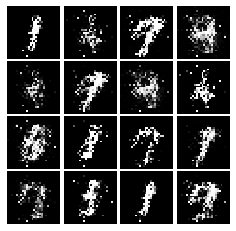


Iter: 1250, D: 0.2091, G:0.4111


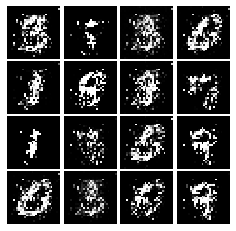


EPOCH:  4
Iter: 1500, D: 0.177, G:0.2324


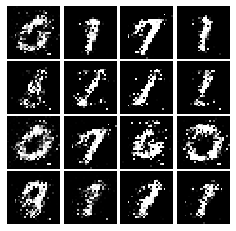


Iter: 1750, D: 0.2005, G:0.1992


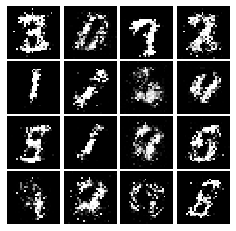


EPOCH:  5
Iter: 2000, D: 0.2164, G:0.1541


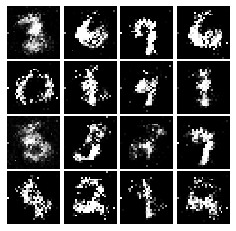


Iter: 2250, D: 0.2378, G:0.1606


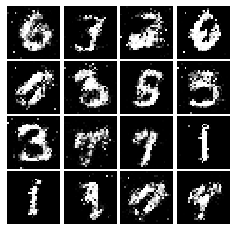


EPOCH:  6
Iter: 2500, D: 0.1906, G:0.2133


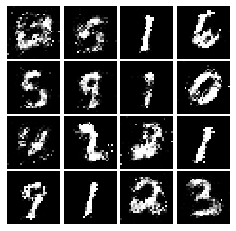


Iter: 2750, D: 0.2308, G:0.1655


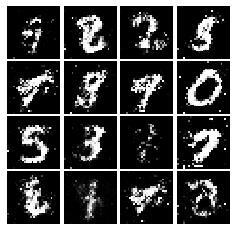


EPOCH:  7
Iter: 3000, D: 0.2043, G:0.1744


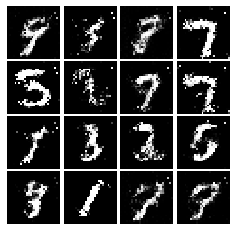


Iter: 3250, D: 0.1871, G:0.1959


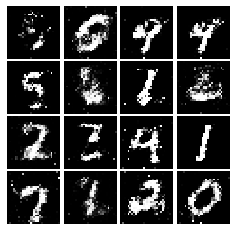


EPOCH:  8
Iter: 3500, D: 0.2146, G:0.1857


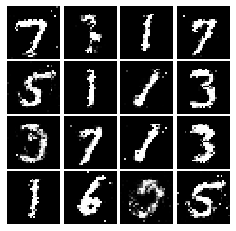


EPOCH:  9
Iter: 3750, D: 0.2134, G:0.1671


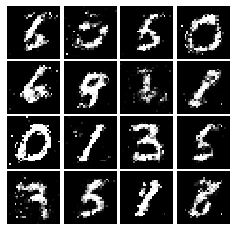


Iter: 4000, D: 0.2451, G:0.169


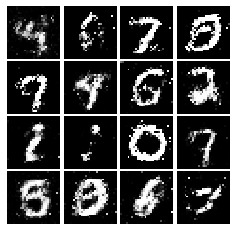


EPOCH:  10
Iter: 4250, D: 0.2212, G:0.1391


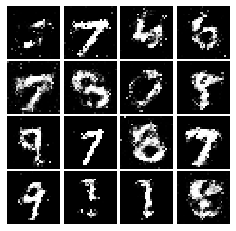


Iter: 4500, D: 0.243, G:0.1596


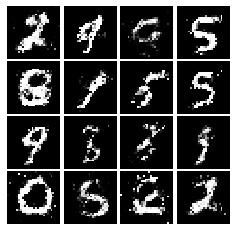

In [18]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)